In [2]:
import sys; sys.path.append("..")
from dataset import AppleQualityDataset, Library
from pgmpy.base import DAG
from pgmpy.models import BayesianNetwork, NaiveBayes
from pgmpy.inference import VariableElimination
from pgmpy.estimators import PC, HillClimbSearch, TreeSearch, MmhcEstimator, ExhaustiveSearch
import bnlearn as bn
import matplotlib.pyplot as plt

data = AppleQualityDataset(data_path="../data/apple_quality.csv", seed=42)

/home/xia/miniconda3/envs/faikr3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
display(data.train_df.head())
display(data.test_df.head())

,size,weight,sweetness,crunchiness,juiciness,ripeness,acidity,quality
3012,0,1,1,0,0,2,1,0
1436,1,0,0,1,2,2,0,0
96,1,0,0,0,2,2,0,0
43,2,2,1,1,0,0,1,0
1814,0,2,0,1,0,2,2,0


,size,weight,sweetness,crunchiness,juiciness,ripeness,acidity,quality
555,2,0,0,1,1,2,1,1
3491,2,2,1,1,1,0,2,0
527,2,1,2,1,0,0,2,0
3925,0,1,2,0,0,2,1,1
2989,0,1,0,0,0,2,0,0


In [4]:
def createPgmpyBN(dag: DAG, data) -> BayesianNetwork:
    model = BayesianNetwork()
    model.add_edges_from(dag.edges())
    model.fit(data.train_df)
    return model


def createBnlearnBN(dag: dict, data) -> dict:
    return bn.parameter_learning.fit(dag, data.train_df, methodtype="ml", verbose=0)

# Manually defined
---

{'accuracy': 0.701, 'precision_macro': 0.7039185054475401, 'recall_macro': 0.7015601560156015, 'f1_macro': 0.7002803731759956}


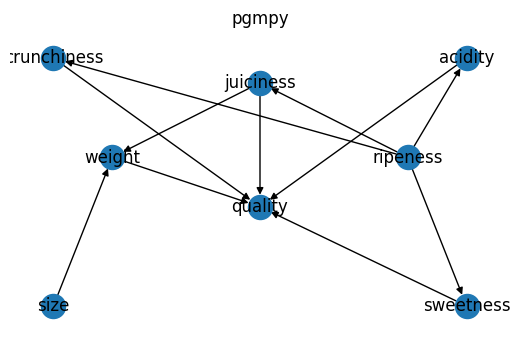

In [5]:
model = BayesianNetwork([
    ("ripeness", "crunchiness"),
    ("ripeness", "sweetness"),
    ("ripeness", "juiciness"),
    ("ripeness", "acidity"),
    ("size", "weight"),
    ("juiciness", "weight"),
    ("juiciness", "quality"),
    ("crunchiness", "quality"),
    ("acidity", "quality"),
    ("sweetness", "quality"),
    ("weight", "quality"),
])
model.fit(data.train_df)

infer = VariableElimination(model)
print(data.evaluate(model, Library.PGMPY))

plt.figure(figsize=(5, 3))
data.plot(model, Library.PGMPY)
plt.show()

# Constraint-based
---

## PC

Working for n conditional variables: 5: 100%|██████████| 5/5 [00:13<00:00,  2.72s/it]
[datazets] >WARNING> PDAG has no faithful extension (= no oriented DAG with the same v-structures as PDAG). Remaining undirected PDAG edges oriented arbitrarily.
Working for n conditional variables: 5: 100%|██████████| 5/5 [00:55<00:00, 11.11s/it]
[datazets] >WARNING> PDAG has no faithful extension (= no oriented DAG with the same v-structures as PDAG). Remaining undirected PDAG edges oriented arbitrarily.
Working for n conditional variables: 5: 100%|██████████| 5/5 [00:52<00:00, 10.57s/it]
[datazets] >WARNING> PDAG has no faithful extension (= no oriented DAG with the same v-structures as PDAG). Remaining undirected PDAG edges oriented arbitrarily.


pgmpy: {'accuracy': 0.757, 'precision_macro': 0.7608318750405081, 'recall_macro': 0.7575857585758576, 'f1_macro': 0.7563663087691085}
bnlearn: {'accuracy': 0.757, 'precision_macro': 0.7608318750405081, 'recall_macro': 0.7575857585758576, 'f1_macro': 0.7563663087691085}


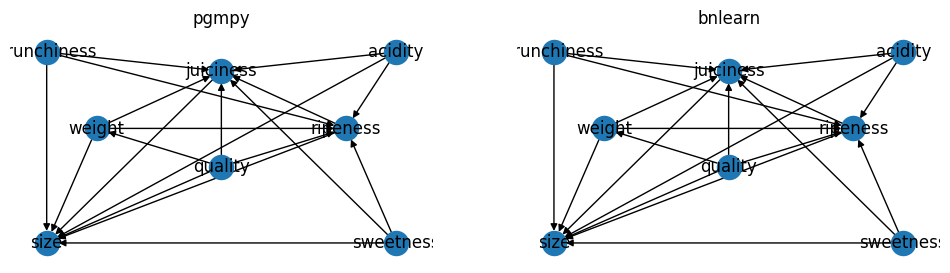

In [6]:
dag_pgmpy = PC(data=data.train_df).estimate(variant="parallel", ci_test="chi_square", significance_level=0.05, max_cond_vars=5)
pgmpy_metrics = data.evaluate(createPgmpyBN(dag_pgmpy, data), Library.PGMPY)

dag_bnlearn = bn.structure_learning.fit(data.train_df, methodtype="cs", verbose=0)
bnlearn_metrics = data.evaluate(createBnlearnBN(dag_bnlearn, data), Library.BNLEARN)

print(f"pgmpy: {pgmpy_metrics}")
print(f"bnlearn: {bnlearn_metrics}")

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
data.plot(dag_pgmpy, Library.PGMPY)
plt.subplot(1, 2, 2)
data.plot(dag_bnlearn, Library.BNLEARN)
plt.show()

# Score-based
---

## Hill-climb search

  0%|          | 16/1000000 [00:00<3:11:07, 87.20it/s]


pgmpy: {'accuracy': 0.796, 'precision_macro': 0.7984165529017111, 'recall_macro': 0.7964396439643964, 'f1_macro': 0.7957352729136962}
bnlearn: {'accuracy': 0.796, 'precision_macro': 0.7984165529017111, 'recall_macro': 0.7964396439643964, 'f1_macro': 0.7957352729136962}


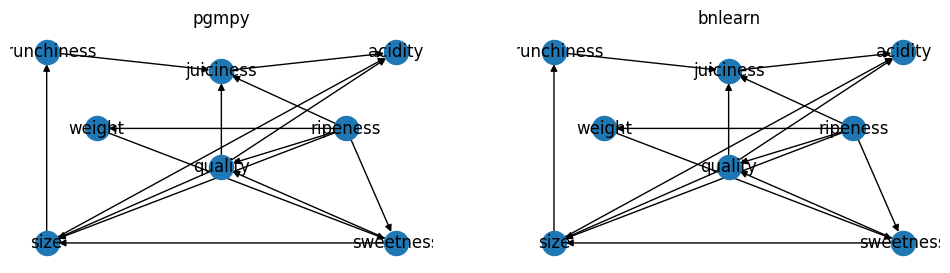

In [7]:
dag_pgmpy = HillClimbSearch(data=data.train_df).estimate(scoring_method="bicscore")
pgmpy_metrics = data.evaluate(createPgmpyBN(dag_pgmpy, data), Library.PGMPY)

dag_bnlearn = bn.structure_learning.fit(data.train_df, methodtype="hc", scoretype="bic", verbose=0)
bnlearn_metrics = data.evaluate(createBnlearnBN(dag_bnlearn, data), Library.BNLEARN)

print(f"pgmpy: {pgmpy_metrics}")
print(f"bnlearn: {bnlearn_metrics}")

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
data.plot(dag_pgmpy, Library.PGMPY)
plt.subplot(1, 2, 2)
data.plot(dag_bnlearn, Library.BNLEARN)
plt.show()

## Max-min hill-climbing

  0%|          | 17/1000000 [00:00<2:24:28, 115.36it/s]


{'accuracy': 0.801, 'precision_macro': 0.801, 'recall_macro': 0.8010301030103011, 'f1_macro': 0.8009950248756219}


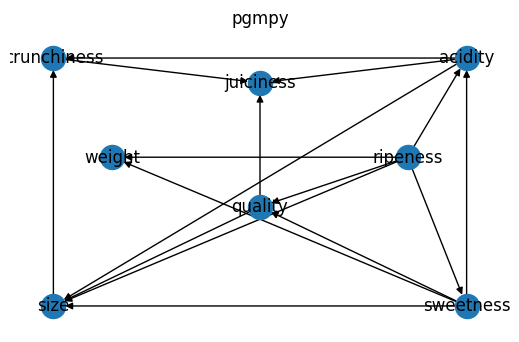

In [8]:
dag_pgmpy = MmhcEstimator(data=data.train_df).estimate()
print(data.evaluate(createPgmpyBN(dag_pgmpy, data), Library.PGMPY))

plt.figure(figsize=(5, 3))
data.plot(dag_pgmpy, Library.PGMPY)
plt.show()

# Tree-based
---

## Chow-Liu

Building tree: 100%|██████████| 28/28.0 [00:00<00:00, 128.66it/s]
Building tree: 100%|██████████| 28/28.0 [00:00<00:00, 11521.68it/s]


pgmpy: {'accuracy': 0.705, 'precision_macro': 0.7075757575757575, 'recall_macro': 0.7055205520552055, 'f1_macro': 0.7044014128610436}
bnlearn: {'accuracy': 0.705, 'precision_macro': 0.7075757575757575, 'recall_macro': 0.7055205520552055, 'f1_macro': 0.7044014128610436}


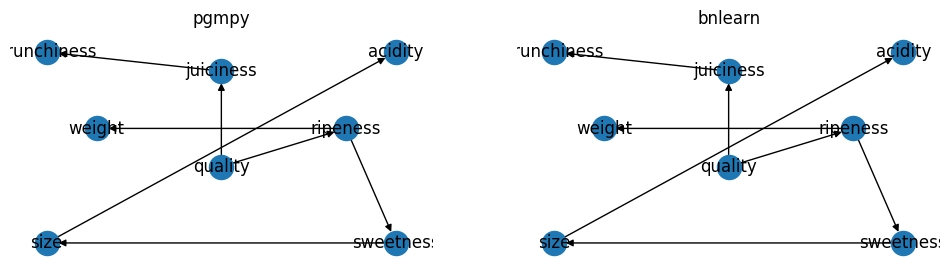

In [10]:
dag_pgmpy = TreeSearch(data=data.train_df, root_node=data.target).estimate(estimator_type="chow-liu")
pgmpy_metrics = data.evaluate(createPgmpyBN(dag_pgmpy, data), Library.PGMPY)

dag_bnlearn = bn.structure_learning.fit(data.train_df, methodtype="cl", root_node=data.target, verbose=0)
bnlearn_metrics = data.evaluate(createBnlearnBN(dag_bnlearn, data), Library.BNLEARN)

print(f"pgmpy: {pgmpy_metrics}")
print(f"bnlearn: {bnlearn_metrics}")

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
data.plot(dag_pgmpy, Library.PGMPY)
plt.subplot(1, 2, 2)
data.plot(dag_bnlearn, Library.BNLEARN)
plt.show()

## Naive Bayes

pgmpy: {'accuracy': 0.715, 'precision_macro': 0.7150038422131147, 'recall_macro': 0.7149014901490149, 'f1_macro': 0.7149176111896338}
bnlearn: {'accuracy': 0.715, 'precision_macro': 0.7150038422131147, 'recall_macro': 0.7149014901490149, 'f1_macro': 0.7149176111896338}


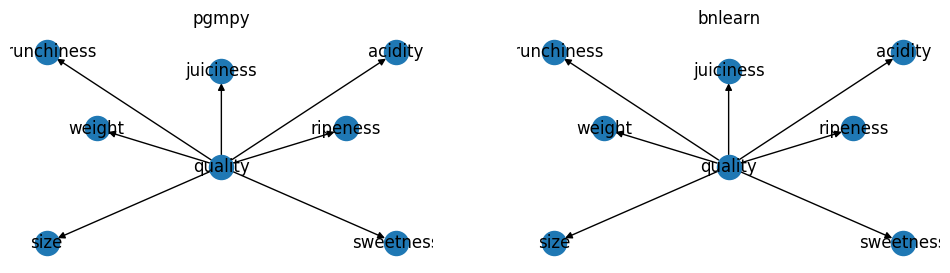

In [11]:
dag_pgmpy = NaiveBayes(data.features, data.target)
pgmpy_metrics = data.evaluate(createPgmpyBN(dag_pgmpy, data), Library.PGMPY)

dag_bnlearn = bn.structure_learning.fit(data.train_df, methodtype="naivebayes", root_node=data.target, verbose=0)
bnlearn_metrics = data.evaluate(createBnlearnBN(dag_bnlearn, data), Library.BNLEARN)

print(f"pgmpy: {pgmpy_metrics}")
print(f"bnlearn: {bnlearn_metrics}")

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
data.plot(dag_pgmpy, Library.PGMPY)
plt.subplot(1, 2, 2)
data.plot(dag_bnlearn, Library.BNLEARN)
plt.show()

## Tree-augmented naive Bayes

Building tree: 100%|██████████| 28/28.0 [00:00<00:00, 8551.08it/s]
Building tree: 100%|██████████| 28/28.0 [00:00<00:00, 22946.56it/s]


pgmpy: {'accuracy': 0.786, 'precision_macro': 0.7867157666123041, 'recall_macro': 0.7862386238623862, 'f1_macro': 0.7859452019717048}
bnlearn: {'accuracy': 0.786, 'precision_macro': 0.7867157666123041, 'recall_macro': 0.7862386238623862, 'f1_macro': 0.7859452019717048}


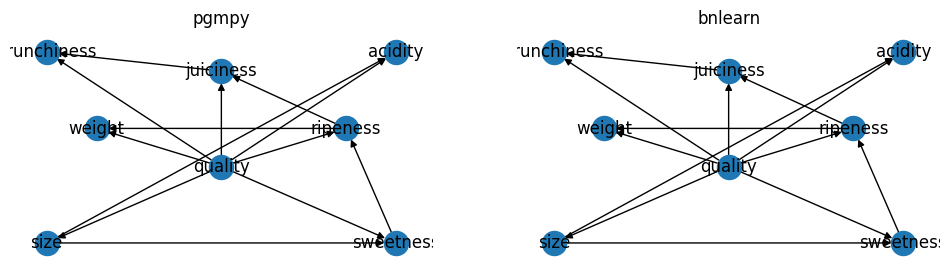

In [12]:
dag_pgmpy = TreeSearch(data=data.train_df, root_node=data.features[0]).estimate(estimator_type="tan", class_node=data.target)
pgmpy_metrics = data.evaluate(createPgmpyBN(dag_pgmpy, data), Library.PGMPY)

dag_bnlearn = bn.structure_learning.fit(data.train_df, methodtype="tan", root_node=data.features[0], class_node=data.target, verbose=0)
bnlearn_metrics = data.evaluate(createBnlearnBN(dag_bnlearn, data), Library.BNLEARN)

print(f"pgmpy: {pgmpy_metrics}")
print(f"bnlearn: {bnlearn_metrics}")

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
data.plot(dag_pgmpy, Library.PGMPY)
plt.subplot(1, 2, 2)
data.plot(dag_bnlearn, Library.BNLEARN)
plt.show()